# Scenario 3 subtask 2: Transform to daily incidence

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

**TASK:** Replicate subplot B in Section 3.2 of https://doi.org/10.1016/j.scitotenv.2022.159326.
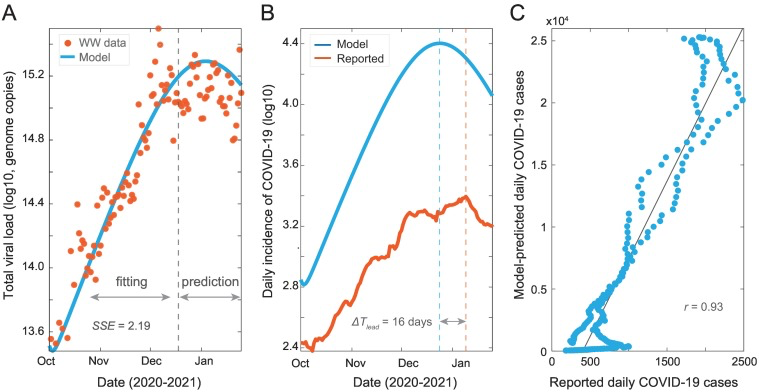

**Specifications:**
1. Equation 9 of paper: $Daily Cases = \sum{t_d}-\sum{(t_d-1)}$ where $\sum$ means cumulative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model
)
import pyciemss.visuals.plots as plots

num_samples = 10
timepoints = [i/10.0 for i in range(1150)]


In [2]:
import pandas as pd
import numpy as np
calibrated_samples = pd.read_csv('data/calibrated_samples_from_wastewater.csv')
calibrated_samples

,timepoint_id,sample_id,lambda_param,alpha_param,gamma_param,k_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,2.951473e-25,1.475737e-25,1.000000e+03,5.000000e-08,2300000.0,1.475737e-25,3.424865e+13,13.534644,0.0
1,1,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,2.890798e-07,1.445399e-07,9.512294e+02,4.846450e+01,2300000.0,1.445399e-07,3.430001e+13,13.535295,0.1
2,2,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,1.132669e-06,5.663343e-07,9.048375e+02,9.396335e+01,2300000.0,5.663343e-07,3.444988e+13,13.537188,0.2
3,3,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,2.496663e-06,1.248331e-06,8.607086e+02,1.366486e+02,2300000.0,1.248331e-06,3.469217e+13,13.540232,0.3
4,4,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,4.348706e-06,2.174353e-06,8.187308e+02,1.766649e+02,2300000.0,2.174353e-06,3.502133e+13,13.544333,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,2256,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322081e-04,4.661041e-04,-5.846748e-12,6.808486e-10,2300000.0,4.661041e-04,1.998685e+14,14.300745,225.6
11301,2257,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322081e-04,4.661041e-04,-5.837446e-12,6.697009e-10,2300000.0,4.661041e-04,1.998685e+14,14.300745,225.7
11302,2258,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322081e-04,4.661041e-04,-5.822378e-12,6.587958e-10,2300000.0,4.661041e-04,1.998685e+14,14.300745,225.8
11303,2259,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322081e-04,4.661041e-04,-5.801503e-12,6.481363e-10,2300000.0,4.661041e-04,1.998685e+14,14.300745,225.9


## Transform Cumulative cases to Incident cases (and log transform that)

In [3]:
calibrated_samples['model_incident_cases'] = calibrated_samples.set_index(['timepoint_id','sample_id'])['C_sol'].groupby('sample_id').diff().reset_index(drop=True).fillna(1.0)
calibrated_samples['model_incident_cases_log10'] = np.log10(calibrated_samples['model_incident_cases'])

calibrated_samples[calibrated_samples['timepoint_days'] <= 115]

/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,timepoint_id,sample_id,lambda_param,alpha_param,gamma_param,k_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days,model_incident_cases,model_incident_cases_log10
0,0,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,2.951473e-25,1.475737e-25,1.000000e+03,5.000000e-08,2300000.0,1.475737e-25,3.424865e+13,13.534644,0.000000,1.000000e+00,0.000000
1,1,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,2.890798e-07,1.445399e-07,9.512294e+02,4.846450e+01,2300000.0,1.445399e-07,3.430001e+13,13.535295,0.100000,2.890798e-07,-6.538982
2,2,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,1.132669e-06,5.663343e-07,9.048375e+02,9.396335e+01,2300000.0,5.663343e-07,3.444988e+13,13.537188,0.200000,8.435888e-07,-6.073869
3,3,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,2.496663e-06,1.248331e-06,8.607086e+02,1.366486e+02,2300000.0,1.248331e-06,3.469217e+13,13.540232,0.300000,1.363994e-06,-5.865187
4,4,0,1.181109e-07,508.611053,0.080463,0.5,0.125,44852600.0,4.348706e-06,2.174353e-06,8.187308e+02,1.766649e+02,2300000.0,2.174353e-06,3.502133e+13,13.544333,0.400000,1.852043e-06,-5.732349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10190,1146,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322075e-04,4.661038e-04,2.489796e-10,8.010842e-04,2300000.0,4.661038e-04,1.998684e+14,14.300745,114.600000,0.000000e+00,-inf
10191,1147,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322076e-04,4.661038e-04,2.458869e-10,7.911331e-04,2300000.0,4.661038e-04,1.998684e+14,14.300745,114.700000,5.820770e-11,-10.235020
10192,1148,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322076e-04,4.661038e-04,2.428325e-10,7.813058e-04,2300000.0,4.661038e-04,1.998684e+14,14.300745,114.799995,0.000000e+00,-inf
10193,1149,4,1.165512e-07,501.649475,0.079902,0.5,0.125,44852600.0,9.322075e-04,4.661038e-04,2.398155e-10,7.715996e-04,2300000.0,4.661038e-04,1.998684e+14,14.300745,114.900000,-5.820770e-11,NaN


## Read in cumulative cases

In [4]:
cases = pd.read_csv('data/datasetCumulCases.csv').dropna(how='any')
incident_cases = cases[['Time', 'cumulativecases']].rename(columns={'cumulativecases': 'reported incident cases', 'Time': 'Timestep'}).set_index('Timestep').diff().dropna()

cases[['Time', 'cumulativecases']].rename(columns={'Time':'Timestep', 'cumulativecases': 'D'}).to_csv('data/cumulative_cases.csv',index=False)
incident_cases

,reported incident cases
Timestep,
1,298.0
2,310.0
3,155.0
4,199.0
5,248.0
...,...
111,1888.0
112,2062.0
113,1800.0


## Plot incident cases predictions against incident case observations

In [5]:
peak_reported = np.argmax(incident_cases.reset_index(drop=True).apply(np.log10))
idxmax = np.argmax(calibrated_samples['model_incident_cases_log10'])
peak_model = calibrated_samples.loc[idxmax, 'timepoint_days']
peak_model



0.0

In [6]:
schema = plots.trajectories(calibrated_samples[calibrated_samples['timepoint_days'] <= 115], keep='model_incident_cases_log10',
                            markers={"Peak model": peak_model, "Peak reported": peak_reported},
                           points=incident_cases.reset_index(drop=True).apply(np.log10)
                           )
schema = plots.pad(schema, 5)


schema
plots.ipy_display(schema)

/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: inv

/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/

In [7]:
from mira.sources.askenet import model_from_json_file

template_model = model_from_json_file('ES3_detection_log10V.json')
template_model.parameters['lambda'].value = 9.06e-8
template_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 9e-8, "maximum":2 * 9.06e-8})
template_model.parameters['gamma'].value = 0.125
template_model.parameters['beta'].value = 44852600
template_model

TemplateModel(templates=[ControlledConversion(rate_law=I*S*lambda/(E + I + S), name='t1', type='ControlledConversion', controller=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), subject=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), outcome=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalConversion(rate_law=E*k, name='t2', type='NaturalConversion', subject=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), outcome=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalDegradation(rate_law=I*delta, name='t3', type='NaturalDegradation', su

In [8]:
prior_samples = load_and_sample_petri_model(template_model, num_samples, timepoints, method='dopri5',  visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")


,lambda_param,alpha_param,gamma_param,k_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days,model_incident_cases,model_incident_cases_log10
timepoint_id,,,,,,,,,,,,,,,,,
0,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,3.045374e-25,1.522687e-25,1.000000e+03,5.000000e-08,2300000.0,1.522687e-25,3.424865e+13,13.534644,0.0,1.000000e+00,0.000000
1,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,2.982768e-07,1.491384e-07,9.512294e+02,4.846450e+01,2300000.0,1.491384e-07,3.429967e+13,13.535290,0.1,2.982768e-07,-6.525723
2,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,1.168704e-06,5.843522e-07,9.048375e+02,9.396335e+01,2300000.0,5.843522e-07,3.444856e+13,13.537171,0.2,8.704276e-07,-6.060609
3,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,2.576095e-06,1.288048e-06,8.607086e+02,1.366486e+02,2300000.0,1.288048e-06,3.468931e+13,13.540196,0.3,1.407391e-06,-5.851927
4,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,4.487060e-06,2.243530e-06,8.187308e+02,1.766649e+02,2300000.0,2.243530e-06,3.501619e+13,13.544269,0.4,1.910964e-06,-5.719089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,9.747377e-04,4.873689e-04,-1.574318e-12,6.687048e-10,2300000.0,4.873689e-04,2.009502e+14,14.302981,225.6,0.000000e+00,NaN
2257,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,9.747377e-04,4.873689e-04,-1.465562e-12,6.586267e-10,2300000.0,4.873689e-04,2.009502e+14,14.302981,225.7,0.000000e+00,NaN
2258,1.218686e-07,504.881146,0.079814,0.5,0.125,44852600.0,9.747377e-04,4.873689e-04,-1.354118e-12,6.488020e-10,2300000.0,4.873689e-04,2.009502e+14,14.302981,225.8,1.164154e-11,NaN


In [12]:
prior_samples['data']['Incident'] = prior_samples['data'].set_index(['timepoint_id','sample_id'])['C_sol'].groupby('sample_id').diff().reset_index(drop=True).fillna(1.0)
prior_samples['data']['IncidentLog10'] = np.log10(prior_samples['data']['Incident'])

prior_samples['data']


/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,timepoint_id,sample_id,lambda_param,alpha_param,k_param,delta_param,beta_param,gamma_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days,Incident,IncidentLog10
0,0,0,1.596486e-07,637.607544,0.5,0.125,44852600.0,0.125,3.989455e-25,1.994727e-25,1.000000e+03,5.000000e-08,2300000.0,1.994727e-25,3.424865e+13,13.534644,0.0,1.000000e+00,0.000000
1,1,0,1.596486e-07,637.607544,0.5,0.125,44852600.0,0.125,3.907443e-07,1.953722e-07,9.512294e+02,4.846450e+01,2300000.0,1.953722e-07,3.430992e+13,13.535420,0.1,3.907443e-07,-6.408107
2,2,0,1.596486e-07,637.607544,0.5,0.125,44852600.0,0.125,1.531009e-06,7.655044e-07,9.048375e+02,9.396335e+01,2300000.0,7.655044e-07,3.448871e+13,13.537677,0.2,1.140265e-06,-5.942994
3,3,0,1.596486e-07,637.607544,0.5,0.125,44852600.0,0.125,3.374699e-06,1.687349e-06,8.607086e+02,1.366486e+02,2300000.0,1.687349e-06,3.477775e+13,13.541302,0.3,1.843690e-06,-5.734312
4,4,0,1.596486e-07,637.607544,0.5,0.125,44852600.0,0.125,5.878075e-06,2.939038e-06,8.187308e+02,1.766649e+02,2300000.0,2.939038e-06,3.517038e+13,13.546177,0.4,2.503377e-06,-5.601474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,1145,9,1.602139e-07,570.394287,0.5,0.125,44852600.0,0.125,1.281433e-03,6.407164e-04,3.465608e-10,8.111645e-04,2300000.0,6.407164e-04,2.133344e+14,14.329061,114.5,1.164153e-10,-9.933990
11496,1146,9,1.602139e-07,570.394287,0.5,0.125,44852600.0,0.125,1.281433e-03,6.407164e-04,3.422559e-10,8.010881e-04,2300000.0,6.407164e-04,2.133344e+14,14.329061,114.6,0.000000e+00,-inf
11497,1147,9,1.602139e-07,570.394287,0.5,0.125,44852600.0,0.125,1.281433e-03,6.407163e-04,3.380033e-10,7.911377e-04,2300000.0,6.407163e-04,2.133344e+14,14.329061,114.7,-1.164153e-10,NaN
11498,1148,9,1.602139e-07,570.394287,0.5,0.125,44852600.0,0.125,1.281433e-03,6.407163e-04,3.338043e-10,7.813095e-04,2300000.0,6.407163e-04,2.133344e+14,14.329061,114.8,0.000000e+00,-inf


<Axes: xlabel='lambda_param', ylabel='Incident'>

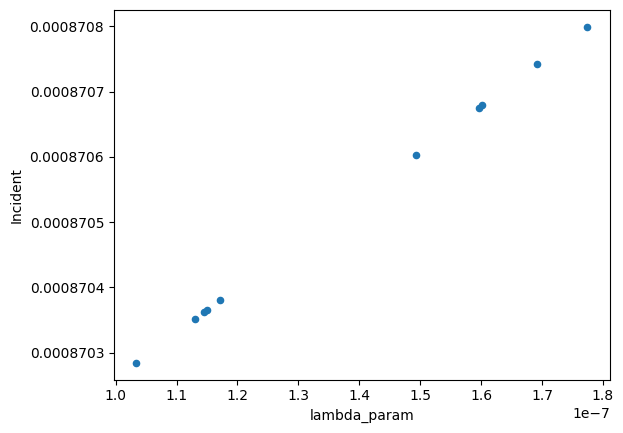

In [13]:
prior_samples['data'].groupby(['sample_id']).mean()[['lambda_param', 'Incident']].plot.scatter(x='lambda_param', y='Incident')

## Read in cumulative cases

In [14]:
cases = pd.read_csv('data/datasetCumulCases.csv').dropna(how='any')
incident_cases = cases[['Time', 'cumulativecases']].rename(columns={'cumulativecases': 'incident cases', 'Time': 'Timestep'}).set_index('Timestep').diff().dropna()

cases[['Time', 'cumulativecases']].rename(columns={'Time':'Timestep', 'cumulativecases': 'D'}).to_csv('data/cumulative_cases.csv',index=False)

In [15]:
schema = plots.trajectories(prior_samples['data'], keep='IncidentLog10',
                            #markers={"Training": 77},
                           points=incident_cases.reset_index(drop=True).apply(np.log10)
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)


/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: inv

/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/zuck016/.pyenv/versions/clean-build/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:
from IPython.display import HTML
posterior_samples = load_and_calibrate_and_sample_petri_model(template_model, 'data/cumulative_cases.csv', num_samples, timepoints,                                                              
                                                              num_iterations=200, verbose=True,
                                                              method='dopri5',  visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")
